# Basic Neural Network Layers

BrainState provides a comprehensive set of pre-built layers for building neural networks. This tutorial covers the essential building blocks.

You will learn about:

- 📏 **Linear layers** - Fully connected transformations
- 🔲 **Convolutional layers** - Spatial feature extraction (1D, 2D, 3D)
- 🏊 **Pooling layers** - Downsampling operations
- 💧 **Dropout layers** - Regularization techniques
- 🔧 **Utility layers** - Flatten, reshape, and more

These layers are optimized, well-tested, and ready to use in your models!

In [7]:

import brainstate
from brainstate import environ
import brainunit as u
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np



## 1. Linear (Fully Connected) Layers

Linear layers perform the transformation: **y = Wx + b**.

BrainState linear modules expect feature shapes as tuples so they can validate tensor shapes. For example, use `Linear(in_size=(10,), out_size=(5,))`.

### Basic Usage


In [8]:

# Create a linear layer
brainstate.random.seed(42)
linear = brainstate.nn.Linear(in_size=(10,), out_size=(5,))

print("Linear Layer:")
print(linear)
print(f"Weight shape: {linear.weight.value['weight'].shape}")
print(f"Bias shape: {linear.weight.value['bias'].shape}")

# Forward pass
x = brainstate.random.randn(10)
y = linear(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {y.shape}")
print(f"Output: {y}")


Linear Layer:
Linear(
  in_size=(10,),
  out_size=(5,),
  w_mask=None,
  weight=ParamState(
    value={
      'bias': ShapedArray(float32[5]),
      'weight': ShapedArray(float32[10,5])
    }
  )
)
Weight shape: (10, 5)
Bias shape: (5,)
Input shape: (10,)
Output shape: (5,)
Output: [ 0.24681929  1.2860886  -1.6367221   0.29457197 -0.9486235 ]


### Batch Processing

Linear layers automatically handle batched inputs:

In [9]:
# Batched input: (batch_size, features)
x_batch = brainstate.random.randn(32, 10)  # 32 samples, 10 features each
y_batch = linear(x_batch)

print(f"Batched input shape: {x_batch.shape}")
print(f"Batched output shape: {y_batch.shape}")

# Works with arbitrary batch dimensions
x_multi = brainstate.random.randn(8, 4, 10)  # (batch1, batch2, features)
y_multi = linear(x_multi)

print(f"\nMulti-batch input: {x_multi.shape}")
print(f"Multi-batch output: {y_multi.shape}")

Batched input shape: (32, 10)
Batched output shape: (32, 5)

Multi-batch input: (8, 4, 10)
Multi-batch output: (8, 4, 5)



### Linear Layer Variants

BrainState provides specialized linear layers:

- `ScaledWSLinear` applies weight standardization for stable training.
- `LoRA` adds low-rank adapters to an existing projection.
- `SparseLinear` consumes a `brainunit.sparse` matrix so you can encode custom connectivity patterns.


In [10]:

# SparseLinear: For sparse connectivity
brainstate.random.seed(0)
dense_weight = brainstate.random.rand(100, 50)
sparsity_mask = brainstate.random.rand(100, 50) < 0.1
sparse_matrix = u.sparse.CSR.fromdense(dense_weight * sparsity_mask)
sparse_linear = brainstate.nn.SparseLinear(sparse_matrix, in_size=(100,))

print("Sparse Linear Layer:")
print(sparse_linear)

x = brainstate.random.rand(100)
y = sparse_linear(x)
print(f"Input: {x.shape} → Output: {y.shape}")


Sparse Linear Layer:
SparseLinear(
  in_size=(100,),
  out_size=(50,),
  spar_mat=CSR(float32[100, 50], nse=485),
  weight=ParamState(
    value={
      'weight': ShapedArray(float32[485])
    }
  )
)
Input: (100,) → Output: (50,)



## 2. Convolutional Layers

Convolutional layers extract spatial features using learnable filters. Supply the expected input shape (without the batch dimension) via `in_size` so each layer can initialize weights and validate its inputs.

### Conv1d - 1D Convolution

Used for sequential data (time series, audio, text):


In [11]:

# Conv1d: (batch, length, in_channels) → (batch, length, out_channels)
brainstate.random.seed(0)
conv1d = brainstate.nn.Conv1d(
    in_size=(100, 3),
    out_channels=16,
    kernel_size=3,
    padding='SAME'
)

print("Conv1d Layer:")
print(conv1d)

# Input: (batch=4, length=100, channels=3)
x = brainstate.random.randn(4, 100, 3)
y = conv1d(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {y.shape}")
print(f"Kernel shape: {conv1d.weight.value['weight'].shape}")


Conv1d Layer:
Conv1d(
  in_size=(100, 3),
  out_size=(100, 16),
  channel_first=False,
  channels_last=True,
  in_channels=3,
  out_channels=16,
  stride=(1,),
  kernel_size=(3,),
  lhs_dilation=(1,),
  rhs_dilation=(1,),
  groups=1,
  dimension_numbers=ConvDimensionNumbers(lhs_spec=(0, 2, 1), rhs_spec=(2, 1, 0), out_spec=(0, 2, 1)),
  padding=SAME,
  kernel_shape=(3, 3, 16),
  w_mask=None,
  w_initializer=XavierNormal(
    scale=1.0,
    mode='fan_avg',
    in_axis=-2,
    out_axis=-1,
    distribution='truncated_normal',
    rng=RandomState([1797259609 2579123966]),
    unit=Unit(10.0^0)
  ),
  b_initializer=None,
  weight=ParamState(
    value={
      'weight': ShapedArray(float32[3,3,16])
    }
  )
)
Input shape: (4, 100, 3)
Output shape: (4, 100, 16)
Kernel shape: (3, 3, 16)


### Conv2d - 2D Convolution

The workhorse for image processing:

In [12]:

# Conv2d: (batch, height, width, in_channels) → (batch, height, width, out_channels)
conv2d = brainstate.nn.Conv2d(
    in_size=(28, 28, 3),      # (height, width, channels)
    out_channels=32,          # 32 feature maps
    kernel_size=(3, 3),       # 3x3 kernel
    stride=(1, 1),            # Stride of 1
    padding='SAME'
)

print("Conv2d Layer:")
print(conv2d)

# Input: (batch=8, height=28, width=28, channels=3)
x_image = brainstate.random.randn(8, 28, 28, 3)
y_image = conv2d(x_image)

print(f"Input shape: {x_image.shape}")
print(f"Output shape: {y_image.shape}")
print(f"Kernel shape: {conv2d.weight.value['weight'].shape}")


Conv2d Layer:
Conv2d(
  in_size=(28, 28, 3),
  out_size=(28, 28, 32),
  channel_first=False,
  channels_last=True,
  in_channels=3,
  out_channels=32,
  stride=(1, 1),
  kernel_size=(3, 3),
  lhs_dilation=(1, 1),
  rhs_dilation=(1, 1),
  groups=1,
  dimension_numbers=ConvDimensionNumbers(lhs_spec=(0, 3, 1, 2), rhs_spec=(3, 2, 0, 1), out_spec=(0, 3, 1, 2)),
  padding=SAME,
  kernel_shape=(3, 3, 3, 32),
  w_mask=None,
  w_initializer=XavierNormal(
    scale=1.0,
    mode='fan_avg',
    in_axis=-2,
    out_axis=-1,
    distribution='truncated_normal',
    rng=RandomState([ 683029726 1624662641]),
    unit=Unit(10.0^0)
  ),
  b_initializer=None,
  weight=ParamState(
    value={
      'weight': ShapedArray(float32[3,3,3,32])
    }
  )
)
Input shape: (8, 28, 28, 3)
Output shape: (8, 28, 28, 32)
Kernel shape: (3, 3, 3, 32)


### Visualizing Convolutional Features

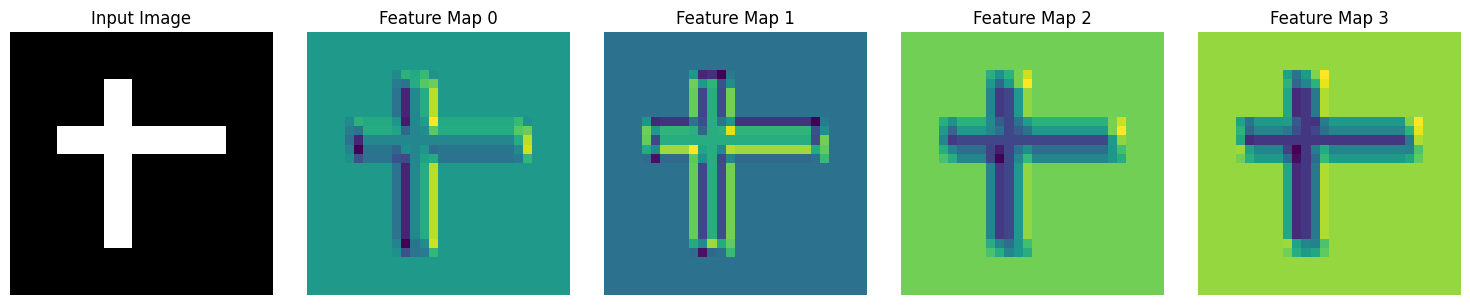

In [13]:

# Create a simple image with a pattern
def create_test_image():
    img = jnp.zeros((28, 28, 1))
    # Add vertical edge
    img = img.at[5:23, 10:13, 0].set(1.0)
    # Add horizontal edge
    img = img.at[10:13, 5:23, 0].set(1.0)
    return img

# Create and apply conv
brainstate.random.seed(42)
edge_conv = brainstate.nn.Conv2d(
    in_size=(28, 28, 1),
    out_channels=4,
    kernel_size=(3, 3),
    padding='SAME'
)

test_img = create_test_image()
features = edge_conv(test_img[None, ...])[0]  # Add/remove batch dim

# Visualize
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

# Original image
axes[0].imshow(test_img[:, :, 0], cmap='gray')
axes[0].set_title('Input Image')
axes[0].axis('off')

# Feature maps
for i in range(4):
    axes[i+1].imshow(np.array(features[:, :, i]), cmap='viridis')
    axes[i+1].set_title(f'Feature Map {i}')
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()



### Convolution Parameters

Understanding stride and padding (`stride=...`, `padding=...`):

- `stride` controls the step size; pass it with the `stride` keyword (the API no longer accepts `strides`).
- `'SAME'` padding preserves spatial dimensions when the stride is 1; `'VALID'` performs no padding.
- Explicit tuples let you set different values per spatial dimension.


In [14]:

# Different stride values
x = brainstate.random.randn(1, 28, 28, 3)

configs = [
    {'stride': (1, 1), 'padding': 'SAME', 'name': 'Stride 1, SAME'},
    {'stride': (2, 2), 'padding': 'SAME', 'name': 'Stride 2, SAME'},
    {'stride': (1, 1), 'padding': 'VALID', 'name': 'Stride 1, VALID'},
]

print(f"Input shape: {x.shape}")

for config in configs:
    brainstate.random.seed(0)
    conv = brainstate.nn.Conv2d(
        in_size=(28, 28, 3),
        out_channels=16,
        kernel_size=(3, 3),
        stride=config['stride'],
        padding=config['padding']
    )
    y = conv(x)
    print(f"{config['name']:20s}: {y.shape}")


Input shape: (1, 28, 28, 3)
Stride 1, SAME      : (1, 28, 28, 16)
Stride 2, SAME      : (1, 14, 14, 16)
Stride 1, VALID     : (1, 26, 26, 16)


### Conv3d - 3D Convolution

For video or volumetric data:

In [15]:

# Conv3d: (batch, depth, height, width, channels)
conv3d = brainstate.nn.Conv3d(
    in_size=(16, 64, 64, 3),
    out_channels=16,
    kernel_size=(3, 3, 3),
    padding='SAME'
)

# Video input: (batch=2, frames=16, height=64, width=64, channels=3)
x_video = brainstate.random.randn(2, 16, 64, 64, 3)
y_video = conv3d(x_video)

print(f"Video input shape: {x_video.shape}")
print(f"Video output shape: {y_video.shape}")


Video input shape: (2, 16, 64, 64, 3)
Video output shape: (2, 16, 64, 64, 16)


## 3. Pooling Layers

Pooling layers downsample feature maps, reducing spatial dimensions.

### Max Pooling

In [16]:

# MaxPool2d: Takes maximum value in each window
maxpool = brainstate.nn.MaxPool2d(
    kernel_size=(2, 2),
    stride=(2, 2)
)

print("MaxPool2d Layer:")
print(maxpool)

# Input: (batch=4, height=28, width=28, channels=16)
x = brainstate.random.randn(4, 28, 28, 16)
y = maxpool(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {y.shape}")
print(f"Spatial reduction: {x.shape[1]}x{x.shape[2]} → {y.shape[1]}x{y.shape[2]}")


MaxPool2d Layer:
MaxPool2d(
  init_value=-inf,
  computation=<function max at 0x000001EFC3E7C720>,
  pool_dim=2,
  return_indices=False,
  kernel_size=(2, 2),
  stride=(2, 2),
  padding=VALID,
  channel_axis=-1
)
Input shape: (4, 28, 28, 16)
Output shape: (4, 14, 14, 16)
Spatial reduction: 28x28 → 14x14


### Average Pooling

In [17]:

# AvgPool2d: Takes average value in each window
avgpool = brainstate.nn.AvgPool2d(
    kernel_size=(2, 2),
    stride=(2, 2)
)

y_avg = avgpool(x)

print("AvgPool2d Layer:")
print(avgpool)
print(f"Output shape: {y_avg.shape}")


AvgPool2d Layer:
AvgPool2d(
  init_value=0.0,
  computation=<function add at 0x000001EFC3E7C400>,
  pool_dim=2,
  return_indices=False,
  kernel_size=(2, 2),
  stride=(2, 2),
  padding=VALID,
  channel_axis=-1
)
Output shape: (4, 14, 14, 16)


### Adaptive Pooling

Pools to a fixed output size regardless of input size:

In [19]:

# AdaptiveAvgPool2d: Always outputs specified size
adaptive_pool = brainstate.nn.AdaptiveAvgPool2d(target_size=(7, 7))

# Works with any input size
inputs = [
    brainstate.random.randn(1, 28, 28, 16),
    brainstate.random.randn(1, 56, 56, 16),
    brainstate.random.randn(1, 224, 224, 16),
]

print("AdaptiveAvgPool2d (output: 7x7)")
for i, x in enumerate(inputs):
    y = adaptive_pool(x)
    print(f"Input {x.shape[1:3]} → Output {y.shape[1:3]}")


AdaptiveAvgPool2d (output: 7x7)
Input (28, 28) → Output (7, 7)
Input (56, 56) → Output (7, 7)
Input (224, 224) → Output (7, 7)


### Comparing Pooling Operations

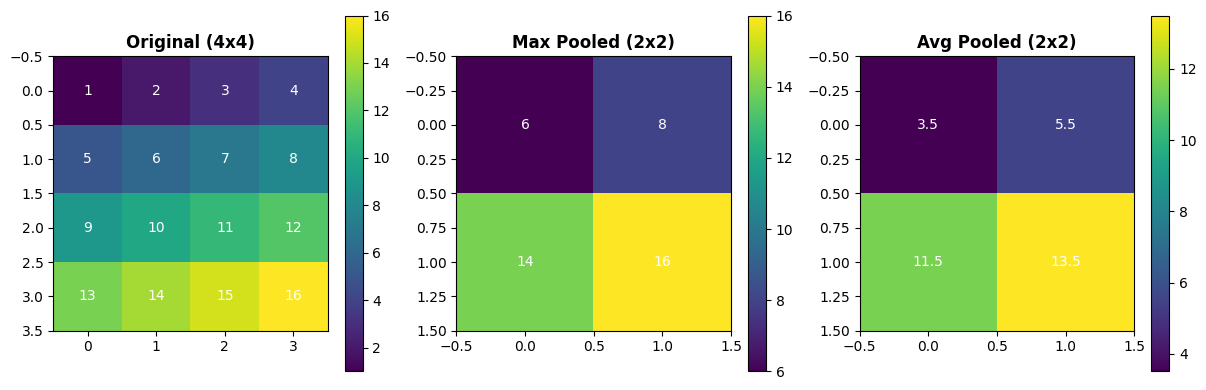

MaxPool takes the maximum value from each 2x2 window
AvgPool takes the average value from each 2x2 window


In [20]:

# Create a simple test pattern
x_test = jnp.array([
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9, 10, 11, 12],
    [13, 14, 15, 16]
], dtype=jnp.float32)

x_test = x_test[None, :, :, None]  # Add batch and channel dims

# Apply different pooling
maxpool_2x2 = brainstate.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
avgpool_2x2 = brainstate.nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2))

y_max = maxpool_2x2(x_test)
y_avg = avgpool_2x2(x_test)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Original
im1 = axes[0].imshow(x_test[0, :, :, 0], cmap='viridis', interpolation='nearest')
axes[0].set_title('Original (4x4)', fontsize=12, fontweight='bold')
for i in range(4):
    for j in range(4):
        axes[0].text(j, i, f'{x_test[0,i,j,0]:.0f}', 
                    ha='center', va='center', color='white', fontsize=10)
plt.colorbar(im1, ax=axes[0])

# Max pooled
im2 = axes[1].imshow(y_max[0, :, :, 0], cmap='viridis', interpolation='nearest')
axes[1].set_title('Max Pooled (2x2)', fontsize=12, fontweight='bold')
for i in range(2):
    for j in range(2):
        axes[1].text(j, i, f'{y_max[0,i,j,0]:.0f}', 
                    ha='center', va='center', color='white', fontsize=10)
plt.colorbar(im2, ax=axes[1])

# Avg pooled
im3 = axes[2].imshow(y_avg[0, :, :, 0], cmap='viridis', interpolation='nearest')
axes[2].set_title('Avg Pooled (2x2)', fontsize=12, fontweight='bold')
for i in range(2):
    for j in range(2):
        axes[2].text(j, i, f'{y_avg[0,i,j,0]:.1f}', 
                    ha='center', va='center', color='white', fontsize=10)
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

print("MaxPool takes the maximum value from each 2x2 window")
print("AvgPool takes the average value from each 2x2 window")



## 4. Dropout and Regularization

Dropout randomly sets activations to zero during training for regularization. Pass `prob` to control the keep probability and enable stochastic behaviour with `environ.context(fit=True)` during training.

### Standard Dropout


In [21]:

# Dropout: Randomly zero out elements
dropout = brainstate.nn.Dropout(prob=0.5)  # Keep 50% of activations during training

print("Dropout Layer:")
print(dropout)

# Create test input
brainstate.random.seed(42)
x = jnp.ones(10)

print("Original:", x)
print("Dropout outputs (training mode):")
with environ.context(fit=True):
    for i in range(3):
        y = dropout(x)
        print(f"  {i + 1}: {y}")

with environ.context(fit=False):
    stable = dropout(x)

print("Evaluation mode:", stable)


Dropout Layer:
Dropout(
  prob=0.5,
  broadcast_dims=()
)
Original: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Dropout outputs (training mode):
  1: [0. 0. 2. 2. 2. 2. 2. 2. 2. 2.]
  2: [2. 2. 2. 2. 0. 2. 0. 0. 0. 2.]
  3: [2. 2. 2. 2. 0. 0. 2. 0. 0. 0.]
Evaluation mode: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]



### Training vs Evaluation Mode

Dropout behaves differently during training and evaluation:

- Wrap forward passes in `with environ.context(fit=True):` to enable dropout.
- Outside that context (or with `fit=False`) dropout becomes a no-op for deterministic evaluation.


In [22]:

class NetworkWithDropout(brainstate.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.linear1 = brainstate.nn.Linear((input_dim,), (hidden_dim,))
        self.dropout = brainstate.nn.Dropout(prob=0.5)
        self.linear2 = brainstate.nn.Linear((hidden_dim,), (output_dim,))

    def update(self, x):
        x = self.linear1(x)
        x = jnp.maximum(0, x)  # ReLU
        x = self.dropout(x)
        x = self.linear2(x)
        return x

# Create network
brainstate.random.seed(0)
net = NetworkWithDropout(10, 20, 5)

# Test input
x = brainstate.random.randn(10)

# Compare outputs in training mode
with environ.context(fit=True):
    y1 = net(x)
    y2 = net(x)

with environ.context(fit=False):
    y_eval = net(x)

print("With dropout (training):")
print(f"  Output 1: {y1}")
print(f"  Output 2: {y2}")
print(f"  Outputs differ: {not jnp.allclose(y1, y2)}")

print("Evaluation mode (dropout off):")
print(f"  Output: {y_eval}")


With dropout (training):
  Output 1: [ 1.7709473  -1.7486901  -0.11733629  0.30774632  1.7717932 ]
  Output 2: [-2.4300232   0.03660802  1.8875287  -1.3981102  -0.3061459 ]
  Outputs differ: True
Evaluation mode (dropout off):
  Output: [-0.44592363 -0.25877538  0.6993926  -1.0398884   0.14154091]


## 5. Utility Layers

### Flatten Layer

Flattens multi-dimensional inputs:

In [25]:
# Flatten: Reshape to 1D
flatten = brainstate.nn.Flatten(start_axis=1)

# Example: After convolution, flatten before fully connected
x_conv = brainstate.random.randn(4, 7, 7, 64)  # (batch, H, W, C)
x_flat = flatten(x_conv)

print(f"Before flatten: {x_conv.shape}")
print(f"After flatten: {x_flat.shape}")
print(f"Flattened: {7 * 7 * 64} = {x_flat.shape[1]} features per sample")


Before flatten: (4, 7, 7, 64)
After flatten: (4, 3136)
Flattened: 3136 = (4, 3136) features per sample


## 6. Building a Complete CNN

Let's combine everything into a complete convolutional neural network:

In [28]:

class SimpleCNN(brainstate.nn.Module):
    'Simple CNN for image classification.'

    def __init__(self, num_classes=10):
        super().__init__()

        # Conv block 1
        self.conv1 = brainstate.nn.Conv2d((32, 32, 3), out_channels=32, kernel_size=(3, 3), padding='SAME')
        self.pool1 = brainstate.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        # Conv block 2
        self.conv2 = brainstate.nn.Conv2d((16, 16, 32), out_channels=64, kernel_size=(3, 3), padding='SAME')
        self.pool2 = brainstate.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        # Conv block 3
        self.conv3 = brainstate.nn.Conv2d((8, 8, 64), out_channels=128, kernel_size=(3, 3), padding='SAME')
        self.pool3 = brainstate.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), in_size=self.conv3.out_size)

        # Flatten and classify
        self.flatten = brainstate.nn.Flatten(in_size=self.pool3.out_size)
        self.fc1 = brainstate.nn.Linear(np.prod(self.flatten.out_size), (256,))  # Assuming 32x32 input
        self.dropout = brainstate.nn.Dropout(prob=0.5)
        self.fc2 = brainstate.nn.Linear((256,), (num_classes,))

    def update(self, x):
        # Conv block 1
        x = self.conv1(x)
        x = jnp.maximum(0, x)  # ReLU
        x = self.pool1(x)

        # Conv block 2
        x = self.conv2(x)
        x = jnp.maximum(0, x)
        x = self.pool2(x)

        # Conv block 3
        x = self.conv3(x)
        x = jnp.maximum(0, x)
        x = self.pool3(x)

        # Classifier
        x = self.flatten(x)
        x = self.fc1(x)
        x = jnp.maximum(0, x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

# Create CNN
brainstate.random.seed(42)
cnn = SimpleCNN(num_classes=10)

print("Simple CNN Architecture:")
print(cnn)

# Test with batch of images
batch_size = 8
images = brainstate.random.randn(batch_size, 32, 32, 3)  # CIFAR-10 size
with brainstate.environ.context(fit=True):
    logits = cnn(images)

print(f"Input shape: {images.shape}")
print(f"Output shape: {logits.shape}")
print(f"Logits for first image: {logits[0]}")


Simple CNN Architecture:
SimpleCNN(
  conv1=Conv2d(
    in_size=(32, 32, 3),
    out_size=(32, 32, 32),
    channel_first=False,
    channels_last=True,
    in_channels=3,
    out_channels=32,
    stride=(1, 1),
    kernel_size=(3, 3),
    lhs_dilation=(1, 1),
    rhs_dilation=(1, 1),
    groups=1,
    dimension_numbers=ConvDimensionNumbers(lhs_spec=(0, 3, 1, 2), rhs_spec=(3, 2, 0, 1), out_spec=(0, 3, 1, 2)),
    padding=SAME,
    kernel_shape=(3, 3, 3, 32),
    w_mask=None,
    w_initializer=XavierNormal(
      scale=1.0,
      mode='fan_avg',
      in_axis=-2,
      out_axis=-1,
      distribution='truncated_normal',
      rng=RandomState([ 827075891 2691092366]),
      unit=Unit(10.0^0)
    ),
    b_initializer=None,
    weight=ParamState(
      value={
        'weight': ShapedArray(float32[3,3,3,32])
      }
    )
  ),
  pool1=MaxPool2d(
    init_value=-inf,
    computation=<function max at 0x000001EFC3E7C720>,
    pool_dim=2,
    return_indices=False,
    kernel_size=(2, 2),
    s

### Visualizing CNN Feature Maps

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3665657..2.0698853].


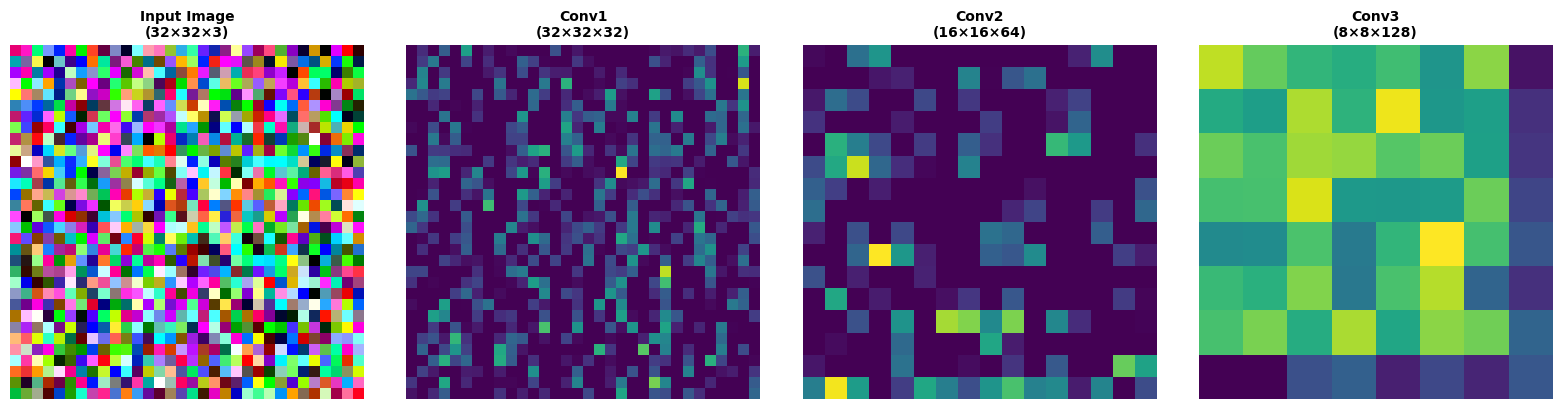

Feature map shapes:
  Layer 1: (1, 32, 32, 32)
  Layer 2: (1, 16, 16, 64)
  Layer 3: (1, 8, 8, 128)


In [29]:
# Get intermediate features
def get_conv_features(model, x):
    """Extract features from each conv layer."""
    features = []
    
    # Conv 1
    x = model.conv1(x)
    x = jnp.maximum(0, x)
    features.append(x)
    x = model.pool1(x)
    
    # Conv 2
    x = model.conv2(x)
    x = jnp.maximum(0, x)
    features.append(x)
    x = model.pool2(x)
    
    # Conv 3
    x = model.conv3(x)
    x = jnp.maximum(0, x)
    features.append(x)
    
    return features

# Extract features
single_image = images[0:1]  # Take first image
features = get_conv_features(cnn, single_image)

# Visualize
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Original image
axes[0].imshow((np.array(single_image[0]) + 1) / 2)  # Normalize to [0,1]
axes[0].set_title('Input Image\n(32×32×3)', fontsize=10, fontweight='bold')
axes[0].axis('off')

# Feature maps
layer_names = ['Conv1\n(32×32×32)', 'Conv2\n(16×16×64)', 'Conv3\n(8×8×128)']
for i, (feat, name) in enumerate(zip(features, layer_names)):
    # Show first feature map from each layer
    feat_map = np.array(feat[0, :, :, 0])
    axes[i+1].imshow(feat_map, cmap='viridis')
    axes[i+1].set_title(name, fontsize=10, fontweight='bold')
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()

print("Feature map shapes:")
for i, feat in enumerate(features):
    print(f"  Layer {i+1}: {feat.shape}")


## Summary

In this tutorial, you learned about:

✅ **Linear layers** - Fully connected transformations  
✅ **Convolutional layers** - 1D, 2D, 3D spatial feature extraction  
✅ **Pooling layers** - Max, average, and adaptive pooling  
✅ **Dropout** - Regularization through random masking  
✅ **Utility layers** - Flatten and reshape operations  
✅ **Complete CNN** - Building end-to-end architectures  

### Key Takeaways

| Layer Type | Use Case | Key Parameters |
|------------|----------|----------------|
| **Linear** | Fully connected | `in_size`, `out_size` |
| **Conv2d** | Image features | `in_size`, `out_channels`, `kernel_size`, `stride`, `padding` |
| **MaxPool2d** | Downsampling | `kernel_size`, `stride` |
| **Dropout** | Regularization | `prob`, `broadcast_dims` |
| **Flatten** | Shape transformation | `start_axis`, `end_axis` |

### Best Practices

1. 🎯 **Use SAME padding** to preserve spatial dimensions
2. 🧮 **Provide the correct `in_size`** so layers can validate incoming tensors
3. 💧 **Add dropout** after dense layers for regularization
4. 🏊 **Pool after activation** - standard practice in CNNs
5. 🔍 **Visualize features** - helps debug and understand the network

### Next Steps

Continue with:
- **Activations & Normalization** - Improve training stability
- **Recurrent Networks** - Handle sequential data
- **Training** - Put it all together with optimization
